In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
rmse = lambda a,b: ((a-b)**2).mean()**0.5

np.random.seed(42)

# Recommender systems

## Morning Objectives

* Describe a recommender system
* Say what makes it differnet than a supervised learning problem
* Describe, implement top-n scores
* Describe, implement similarity recommender, popularity recommender
* Describe the cold start problem

## Afternoon objectives

* Describe and implement user-based collaborative filtering
* Describe distance functions and when to use them
  * Euclidean, Jaccard, Cosine

## Introduction

Recommender systems are systems that make recommendations.

Examples:
 * Netflix: recommends movies and shows
 * Spotify: recommends music
 * Amazon: recommends products
 * Google News: recommends news articles

But this is vague. How can be more precise about what we want from a recommender system?

In the past, companies would simply promote popular and profitable items. But we can do better.

We can cast the recommendation problem to a **supervised learning problem**, where we attempt to predict a user's rating of an item, trained on a corpus of ratings.

If this is just a supervised learning problem, what's special about recommenders? Can't we just load up the user and item features into the feature matrix `X`, stick the ratings in `y`, throw the whole thing into a boosted tree ensemble and take a long lunch?

#### Challenges of recommender systems
* Often don't know much about items or users.
* Care more about picking the top items than getting them all right
* Lots of null values / cold start problem
  * curse of dimensionality; too many features
* Muddled by business logic
  * Netflix didn't really care how much you like the movies
  * They'd rather pick what you watch for you

### Recommenders as supervised learning

In [2]:
df = pd.read_table("data/u.data", names=["user_id", "movie_id", "rating", "timestamp"])
df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# uncomment this if you want to split on users
train_users, test_users = train_test_split( df.user_id.unique() )
train = df[df["user_id"].isin(train_users)]
test = df[df["user_id"].isin(test_users)]

# train = df.sort_values("timestamp").iloc[:int(len(df)*0.8)]
# test = df.sort_values("timestamp").iloc[int(len(df)*0.8):]

In [4]:
X = df[["user_id","movie_id"]]
y = df["rating"]

X_train = train[["user_id","movie_id"]]
y_train = train["rating"]

X_test = test[["user_id","movie_id"]]
y_test = test["rating"]

In [5]:
clf = RandomForestRegressor(n_estimators=50, verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [6]:
yhat = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


In [7]:
rmse(yhat, y_test) 

1.1703385761513205

In [8]:
# find RMSE of always predicting the mean value

yhat_mean = np.full(len(y_test), y_train.mean())
rmse(yhat_mean, y_test)

1.1017600762829554

The ensemble of trees did worse than always predicting the mean movie rating.

## Engineering features

We often know very little about users and items. There's two main strategies.

The first is to simply find some features for the users and/or items. 

In this case, we happen to know a thing or two about the movie-items in this DB.


In [11]:
item_cols = ["movie_id", "movie_title", "release_date", "video_release_date",
              "IMDb_URL", "unknown", "Action", "Adventure", "Animation",
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"]

items_df_plain = pd.read_csv("data/u.item", sep="|", names=item_cols, encoding="latin1")
items_df_plain.release_date = pd.to_datetime(items_df_plain.release_date)
items_df_plain["year"] = items_df_plain.release_date.dt.year
items_df = items_df_plain.drop(labels=["movie_title","release_date","video_release_date","IMDb_URL","unknown"],axis=1)
items_df.head()

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995.0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995.0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995.0
3,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995.0
4,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995.0


In [12]:
item_rating_df = pd.merge(df, items_df, on="movie_id")
item_rating_df.fillna(method="bfill", inplace=True)
item_rating_df.head()

,user_id,movie_id,rating,timestamp,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,196,242,3,881250949,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1997.0
1,63,242,3,875747190,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1997.0
2,226,242,5,883888671,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1997.0
3,154,242,3,879138235,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1997.0
4,306,242,5,876503793,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1997.0


In [13]:
# uncomment this if you want to train on users
train_users, test_users = train_test_split( item_rating_df.user_id.unique() )
train = item_rating_df[item_rating_df["user_id"].isin(train_users)]
test = item_rating_df[item_rating_df["user_id"].isin(test_users)]

# # uncomment this if you want to use a chronological train/test split
# train = item_rating_df.sort_values("timestamp").iloc[:int(len(item_rating_df)*0.8)]
# test = item_rating_df.sort_values("timestamp").iloc[int(len(item_rating_df)*0.8):]

In [14]:
X_train = train.drop("rating", axis=1)
y_train = train["rating"]

X_test = test.drop("rating", axis=1)
y_test = test["rating"]

In [15]:
clf = RandomForestRegressor(n_estimators=50, verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [16]:
yhat = clf.predict(X_test)
test["prediction"] = yhat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
rmse(yhat, y_test) 

1.0831047985464104

We did it! We beat the mean!

### Top-n scores

The problem with RMSE as an error metric, is we don't really care about items that the user doesn't feel strongly about. We mostly care about avoiding items they'll hate, and recommending items they'll love. 

* Precision at n: percentage of top n  predicted ratings that are 'relevant'
* Recall at n: percentage of relevant items in top n predictions
* Lift or hit rate are more relevant to business

In [30]:
# "relevant" movies are the top 10% rated for each user

# "python is readable" they said
get_top_10p_rating_func = lambda x:set(x.sort_values("rating", ascending=False).head(len(x)//10).movie_id)
relevant = test.groupby("user_id").apply(get_top_10p_rating_func)
relevant.head(12)

user_id
4                                            {303, 327}
10    {191, 611, 484, 197, 134, 357, 488, 133, 510, ...
12                            {684, 242, 216, 157, 735}
13    {514, 516, 517, 263, 135, 137, 651, 527, 655, ...
16    {227, 197, 71, 199, 12, 684, 302, 531, 404, 18...
17                                           {475, 150}
30                                  {242, 531, 69, 174}
37                              {161, 226, 597, 56, 62}
39                                           {748, 302}
44    {449, 195, 135, 168, 9, 173, 174, 176, 209, 66...
48                       {195, 132, 661, 183, 187, 191}
54                        {741, 742, 333, 50, 276, 411}
dtype: object

In [31]:
# in the test set, grab the top 5 predicted movie ratings
get_top_5_pred_func = lambda x:set(x.sort_values("prediction", ascending=False).head(5).movie_id)
top_5_pred = test.groupby("user_id").apply(get_top_5_pred_func)
top_5_pred.head(12)

user_id
4      {356, 357, 327, 329, 50}
10      {64, 100, 238, 655, 50}
12    {132, 133, 238, 242, 318}
13     {100, 132, 137, 493, 56}
16      {64, 100, 655, 55, 318}
17        {1, 100, 9, 137, 221}
30     {258, 172, 174, 242, 50}
37      {174, 210, 50, 56, 127}
39    {313, 302, 307, 345, 315}
44    {427, 173, 174, 313, 318}
48    {483, 427, 302, 187, 511}
54       {1, 100, 268, 50, 127}
dtype: object

In [32]:
total_hits = 0
for rel_items, preds in zip(relevant, top_5_pred):
    total_hits += len( rel_items & preds )

Precision at 5:

"Relevant" is here defined as among a user's top 3 movies. We have 5 tries to get them, so our maximum precision will be 3/5, if we picked out all three top movies for every user.

In [33]:
total_hits / (5*len(relevant))

0.19915254237288135

Recall at 5:

On the other hand, recall-at-5 is the fraction of the time we picked out the relevant items - the top-3 movies - given five chances.

In [34]:
total_hits / (3*len(relevant))

0.3319209039548023

**alert alert** Very subtle leakage; only predicted ratings for movies that users rated. We don't know what their rating was when we predicted it, so why is this leakage?

**question**: as `n` increases, what will happen to precision-at-n? Recall-at-n?

**question**: How do you think the mean-predictor will perform on top-n scores?

## Similarity Recommender

If we're using a top-n score, we don't need to use supervised machine learning at all - we can just **recommend the n unrated items most similar to the user profile**.

In [35]:
# here the user profile is the sum of each feature of the top 10% rated item for each user 
f = lambda x:x.sort_values("rating", ascending=False).head(len(x)//10).sum()
profiles = test.groupby("user_id").apply(f).drop(["rating","user_id","movie_id","timestamp","prediction","year"], axis=1)
profiles.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,4.0,0.0,0.0,0.0,2.0,3.0,0.0,11.0,0.0,4.0,1.0,0.0,4.0,3.0,1.0,2.0,3.0,2.0
12,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
13,10.0,2.0,2.0,3.0,19.0,5.0,2.0,32.0,0.0,4.0,1.0,3.0,3.0,11.0,6.0,7.0,5.0,1.0
16,3.0,1.0,2.0,2.0,2.0,3.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,3.0,2.0,4.0,2.0,0.0


In [36]:
profiles.values.shape # n_users, n_features

(236, 18)

In [37]:
movie_profiles = items_df.drop(["movie_id","year"], axis=1).fillna(method="bfill")
movie_profiles.shape #n_movies, n_features

(1682, 18)

Now we have a bunch of user profiles (236, to be exact), and a bunch of movie profiles (1682), each featurized with the same 18 genres.

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
similarity = cosine_similarity(profiles, movie_profiles)

Cell `i, j` is the cosine similarity between the `i`th user and the `j`th movie.

(Quick refresher: cosine similarity it just `cos(theta)` where `theta` is the angle between two vectors `u` and `v`. If the two vectors unit vectors, the `cos(theta)` = `u . v`. Cosine similarity is a convenient metric space for vectors whose semantics are such that they are "the same" if they are pointing in the same direction regardless of their length. Super common example: bag of words vectorization of documents.)

In [41]:
similarity

array([[0.        , 0.        , 0.        , ..., 0.57735027, 0.        ,
        0.81649658],
       [0.07968191, 0.23904572, 0.13801311, ..., 0.68313005, 0.13801311,
        0.75907212],
       [0.33333333, 0.33333333, 0.28867513, ..., 0.61237244, 0.57735027,
        0.57735027],
       ...,
       [0.49518757, 0.49518757, 0.10721125, ..., 0.45485883, 0.42884501,
        0.32163376],
       [0.28867513, 0.4330127 , 0.        , ..., 0.53033009, 0.5       ,
        0.25      ],
       [0.15309311, 0.45927933, 0.26516504, ..., 0.625     , 0.26516504,
        0.70710678]])

In [42]:
# grab the top n recommendations for each user profile

n = 20
top_recs = [set(items_df.iloc[x].movie_id.values) for x in np.argsort(similarity, 1)[:,-n:]]

In [43]:
# see the rate at which these recommendations are relevant; this is the top-n-precision

total_hits = 0
for rel_items, preds in zip(relevant, top_recs):
    total_hits += len( rel_items & preds )

In [44]:
total_hits / (n*len(relevant))

0.05614406779661017

Five and a half percent. Not great! This is about as good as we could expect from recommending movies based _exclusively_ on their genre. But also _way_ better than random recommendations.

**question** brainstorm some improvements on this scheme.

Content-based similarity recommenders rely on good featurizations to do all the heavy lifting. (If we have time, check out this state-of-the-art NLP content-based recommender https://colab.research.google.com/drive/1UyTLgH8ZUp5uJ8POdYKFBxz_TBXPI1MY)

**question** what if we want to recommend items to a user that _has no profile_?

## Popularity Recommenders

In [77]:
popular_movies = set( train.groupby("movie_id").rating.sum() \
                      .sort_values(ascending=False).iloc[0:20].index )

In [78]:
items_df_plain[ items_df_plain.movie_id.isin( popular_movies ) ]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995.0
6,7,Twelve Monkeys (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1995.0
49,50,Star Wars (1977),1977-01-01,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,...,0,0,0,0,1,1,0,1,0,1977.0
55,56,Pulp Fiction (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Pulp%20Fictio...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994.0
97,98,"Silence of the Lambs, The (1991)",1991-01-01,NaN,http://us.imdb.com/M/title-exact?Silence%20of%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1991.0
99,100,Fargo (1996),1997-02-14,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1997.0
116,117,"Rock, The (1996)",1996-06-07,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1996.0
120,121,Independence Day (ID4) (1996),1996-07-03,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1996.0
126,127,"Godfather, The (1972)",1972-01-01,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1972.0
171,172,"Empire Strikes Back, The (1980)",1980-01-01,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,...,0,0,0,0,1,1,0,1,0,1980.0


In [79]:
popular_movies

{1,
 7,
 50,
 56,
 98,
 100,
 117,
 121,
 127,
 172,
 173,
 174,
 181,
 237,
 258,
 286,
 288,
 294,
 300,
 313}

In [80]:
total_hits = 0
for rel_items in relevant:
    total_hits += len( rel_items & popular_movies )

In [81]:
total_hits / (n*len(relevant))

0.0625

In fact, the popularity recommender has a better top-20-precision score than the similarity recommender.

Plain old popularity can work pretty well. People like popular things - that's why they're popular.

This is especially useful for the **cold start problem**: you don't know anything at all about a user - they have no preferences, and they've rated nothing - but you still need to give them a recommendation.

* If you need to give a recommendation, just recommend popular things.
* If you need to guess their rating for an item, just guess the average rating for the item.

#   Afternoon: Collaborative filtering using similarity

##  Overview of CF using similarity

Use similarity to recommend items:

*   Make recommendations based on similarity:
    -   Between users
    -   Between items
*   Similarity measures:
    -   Pearson
    -   Cosine
    -   Jaccard

##  Types of collaborative filtering

Two types of similarity-based CF:

*   *User-based*: predict based on similarities between users
    -   Performs well, but slow if many users
    -   Use item-based CF if $|Users| \gg |Items|$
*   *Item-based*: predict based on similarities between items
    -   Faster if you precompute item-item similarity
    -   Usually $|Users| \gg |Items| \, \Rightarrow$  item-based CF is most popular
    -   Items tend to be more stable:
        -   Items often only in one category (e.g., action films)
        -   Stable over time
        -   Users may like variety or change preferences over time
        -   Items usually have more ratings than users $\Rightarrow$ items have more stable average ratings than users

##  Types of data

Data can be:

*   *Explicit*:
    -   User provided ratings (1 to 5 stars)
    -   User like/non-like
*   *Implicit*:
    -   Infer user-item relationships from behavior
    -   More common
    -   Example: buy/not-buy; view/not-view

To convert implicit to explicit, create a matrix of 1s (yes) and 0s (no).

##  Collaborative filtering recipe

Compute predictions by similarity:

1.  Normalize (demean) utility matrix
1.  Compute similarity of users or items
1.  Predict ratings for unrated items
1.  Add prediction to average rating of user/item

Note:

*   Precompute utility matrix for each user -- it is relatively stable
*   Only compute predictions at runtime


In [90]:
df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [104]:
utility_matrix_df = pd.pivot_table( df, values="rating", index="user_id", columns="movie_id" )

In [105]:
utility_matrix_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
#numpy-ify it

utility_matrix = utility_matrix_df.fillna(0).values
utility_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [107]:
dists = cosine_similarity( utility_matrix )
dists

array([[1.        , 0.16693098, 0.04745954, ..., 0.14861694, 0.17950788,
        0.39817474],
       [0.16693098, 1.        , 0.11059132, ..., 0.16148478, 0.17226781,
        0.10579788],
       [0.04745954, 0.11059132, 1.        , ..., 0.10124256, 0.13341615,
        0.02655587],
       ...,
       [0.14861694, 0.16148478, 0.10124256, ..., 1.        , 0.1016418 ,
        0.09511958],
       [0.17950788, 0.17226781, 0.13341615, ..., 0.1016418 , 1.        ,
        0.18246466],
       [0.39817474, 0.10579788, 0.02655587, ..., 0.09511958, 0.18246466,
        1.        ]])

Text(0.5, 1.0, 'the cosine similarity between all pairs of users')

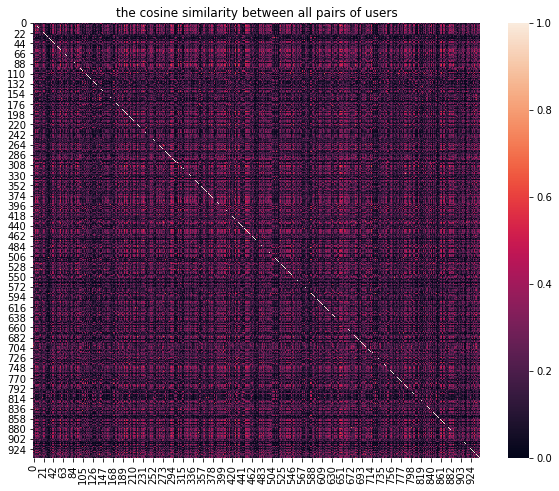

In [124]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap( dists, ax=ax )
ax.set_title("the cosine similarity between all pairs of users")

In [125]:
n = 20
neighborhood = np.argsort( dists, axis=1 )[:,-n:]
neighborhood

array([[300, 726, 885, ..., 863, 915,   0],
       [742, 677, 936, ..., 930, 700,   1],
       [145, 172, 610, ..., 488, 862,   2],
       ...,
       [ 31, 778, 864, ..., 816, 688, 940],
       [449, 733, 660, ...,  90, 453, 941],
       [496, 434, 215, ..., 221, 681, 942]])

Grab the average ratings for all movies, for all users in the neighborhood

In [132]:
utility_matrix_df.iloc[ neighborhood[0] ].mean(axis=0)

movie_id
1       4.050000
2       3.235294
3       2.750000
4       3.789474
5       3.000000
6       5.000000
7       4.000000
8       3.785714
9       4.416667
10      3.833333
11      4.000000
12      4.684211
13      3.900000
14      4.000000
15      3.750000
16      3.333333
17      3.230769
18      4.000000
19      4.500000
20      3.750000
21      2.625000
22      4.210526
23      3.909091
24      3.500000
25      3.562500
26      3.555556
27      2.700000
28      3.894737
29      2.285714
30      3.500000
          ...   
1653         NaN
1654         NaN
1655    2.000000
1656         NaN
1657    3.000000
1658         NaN
1659         NaN
1660         NaN
1661         NaN
1662         NaN
1663         NaN
1664         NaN
1665         NaN
1666         NaN
1667         NaN
1668         NaN
1669         NaN
1670         NaN
1671         NaN
1672         NaN
1673         NaN
1674         NaN
1675         NaN
1676         NaN
1677         NaN
1678         NaN
1679         NaN
1680 

The process for converting this recipe into a functioning recommender is the subject of this afternoon's assignment.

##  Choosing a similarity measure

Chose the appropriate similarity measure for your data:

*   Cosine:
    -   Use for ratings (non-Boolean) data
    -   Treat missing ratings as $0$
    -   Cosine + de-meaned data is the same as Pearson
*   Jaccard:
    -   Use only Boolean (e.g., buy/not buy) data
    -   Loses information with ratings data

Then compute *similarity matrix* of pair-wise similarities between items (users)

##  Predict ratings from similarity

Predict using a similarity-weighted average of ratings:

$$\hat{r}_{ui} = \dfrac{\underset{j\in I_u}{\sum} similarity(i,j) \cdot R_{uj} }{\underset{j \in I_u}{\sum } similarity(i,j) }$$

where

*   $\hat{r}_{ui}$ is user $u$'s predicted rating for item $i$
*   $I_u \equiv$  set of items rated by $u$
*   $R_{uj}$ is utility matrix, i.e., $R_{uj} \equiv$ user $u$'s rating of item $j$

$\Rightarrow$ Compute similarity between items!

##  Recommend best items

Recommend items with highest predicted rating:

*   Sort predicted ratings $\hat{r}_{ui}$
*   Optimize by only searching a neighborhood which contains the $n$ items most similar to $i$
*   Beware:
    -   Consumers like variety
    -   Don't recommend every Star Trek film to someone who liked first film
    -   Best to offer several different types of item